# Task
Clean the "adult_corrected.csv" dataset for machine learning algorithms using pyspark step by step with comments.

## Install and initialize pyspark

### Subtask:
Set up the PySpark environment in the notebook.


In [2]:
%pip install pyspark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AdultDataCleaning").getOrCreate()

## Load the dataset

### Subtask:
Load the `adult_corrected.csv` file into a PySpark DataFrame.


In [4]:
df_spark = spark.read.csv('/content/adult_corrected.csv', header=True, inferSchema=True)

df_spark.printSchema()

df_spark.show(5)

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education_num|marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------

## Handle missing values

### Subtask:
Identify and handle missing values in the DataFrame. This might involve imputation or removal of rows/columns with missing data.


In [5]:
from pyspark.sql.functions import col, when, count

# Define the string representing missing values
missing_value = "?"

# Identify columns with string type that might contain '?'
string_columns = [f.name for f in df_spark.schema.fields if f.dataType.typeName() == 'string']

# Count missing values in each string column
missing_counts = df_spark.select([count(when(col(c) == missing_value, True)).alias(c) for c in string_columns])

# Show the counts of missing values
missing_counts.show()

+---------+---------+--------------+----------+------------+----+---+--------------+------+
|workclass|education|marital_status|occupation|relationship|race|sex|native_country|income|
+---------+---------+--------------+----------+------------+----+---+--------------+------+
|     1836|        0|             0|      1843|           0|   0|  0|           583|     0|
+---------+---------+--------------+----------+------------+----+---+--------------+------+



In [6]:
from pyspark.sql.functions import mode

# Calculate the mode for columns with missing values
workclass_mode = df_spark.groupBy("workclass").count().orderBy("count", ascending=False).first()[0]
occupation_mode = df_spark.groupBy("occupation").count().orderBy("count", ascending=False).first()[0]
native_country_mode = df_spark.groupBy("native_country").count().orderBy("count", ascending=False).first()[0]

# Replace '?' with the calculated mode in the respective columns
df_spark = df_spark.withColumn("workclass", when(col("workclass") == missing_value, workclass_mode).otherwise(col("workclass")))
df_spark = df_spark.withColumn("occupation", when(col("occupation") == missing_value, occupation_mode).otherwise(col("occupation")))
df_spark = df_spark.withColumn("native_country", when(col("native_country") == missing_value, native_country_mode).otherwise(col("native_country")))

# Verify that missing values have been handled
missing_counts_after = df_spark.select([count(when(col(c) == missing_value, True)).alias(c) for c in string_columns])
missing_counts_after.show()

+---------+---------+--------------+----------+------------+----+---+--------------+------+
|workclass|education|marital_status|occupation|relationship|race|sex|native_country|income|
+---------+---------+--------------+----------+------------+----+---+--------------+------+
|        0|        0|             0|         0|           0|   0|  0|             0|     0|
+---------+---------+--------------+----------+------------+----+---+--------------+------+



## Handle categorical variables

### Subtask:
Convert categorical features into a numerical format that can be used by machine learning algorithms using techniques like One-Hot Encoding.


In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.types import StringType

# 1. Identify the categorical columns
categorical_cols = [field.name for field in df_spark.schema.fields if isinstance(field.dataType, StringType)]

# Remove the target variable 'income' if it's in the list
if 'income' in categorical_cols:
    categorical_cols.remove('income')

# Create stages for the pipeline
stages = []
indexed_cols = [col + "_indexed" for col in categorical_cols]
encoded_cols = [col + "_encoded" for col in categorical_cols]

# 3. and 4. For each categorical column, create StringIndexer and OneHotEncoder
for i, col in enumerate(categorical_cols):
    indexer = StringIndexer(inputCol=col, outputCol=indexed_cols[i])
    encoder = OneHotEncoder(inputCol=indexed_cols[i], outputCol=encoded_cols[i])
    stages.append(indexer)
    stages.append(encoder)

# Import Pipeline and create a pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the data and transform it
pipeline_model = pipeline.fit(df_spark)
df_encoded = pipeline_model.transform(df_spark)

# 5. Drop original categorical columns and intermediate indexed columns
columns_to_drop = categorical_cols + indexed_cols
df_ml_ready = df_encoded.drop(*columns_to_drop)

# Show the schema and some rows of the resulting DataFrame
df_ml_ready.printSchema()
df_ml_ready.show(5)

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- income: string (nullable = true)
 |-- workclass_encoded: vector (nullable = true)
 |-- education_encoded: vector (nullable = true)
 |-- marital_status_encoded: vector (nullable = true)
 |-- occupation_encoded: vector (nullable = true)
 |-- relationship_encoded: vector (nullable = true)
 |-- race_encoded: vector (nullable = true)
 |-- sex_encoded: vector (nullable = true)
 |-- native_country_encoded: vector (nullable = true)

+---+------+-------------+------------+------------+--------------+------+-----------------+-----------------+----------------------+------------------+--------------------+-------------+-----------+----------------------+
|age|fnlwgt|education_num|capital_gain|capital_loss|hours_per_week|income|workcl

## Handle numerical features

### Subtask:
Scale numerical features if necessary.


In [13]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.linalg import VectorUDT, DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, ArrayType

# 1. Identify the numerical columns in the df_ml_ready DataFrame.
# We need to exclude the vector columns which are already one-hot encoded
numerical_cols = [field.name for field in df_ml_ready.schema.fields if field.dataType != VectorUDT() and field.name != 'income']

# Convert numerical columns to DoubleType if they are not already (StandardScaler requires DoubleType)
for col_name in numerical_cols:
    df_ml_ready = df_ml_ready.withColumn(col_name, col(col_name).cast(DoubleType()))

# Assemble numerical features into a single vector column for StandardScaler
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
df_assembled = assembler.transform(df_ml_ready)

# 2. Choose an appropriate scaling method: StandardScaler
# 3. Create a scaler instance
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=False)

# 4. Fit the scaler to your df_ml_ready DataFrame
scaler_model = scaler.fit(df_assembled)

# 5. Transform the df_ml_ready DataFrame using the fitted scaler
df_scaled = scaler_model.transform(df_assembled)

# Convert the scaled sparse vector to a dense vector to facilitate element extraction
to_dense_udf = udf(lambda v: v.toArray().tolist() if v is not None else None, ArrayType(DoubleType()))
df_dense_scaled = df_scaled.withColumn("scaled_numerical_features_dense", to_dense_udf(col("scaled_numerical_features")))


# 6. Replace the original numerical columns with the scaled ones
# Extract scaled features from the dense vector and create new columns
def extract_scaled_feature_from_vector(index):
    def _(vector):
        if vector is None or index >= len(vector):
            return None
        return float(vector[index])
    return udf(_, DoubleType())

for i, col_name in enumerate(numerical_cols):
    df_dense_scaled = df_dense_scaled.withColumn(f"{col_name}_scaled", extract_scaled_feature_from_vector(i)(col("scaled_numerical_features_dense")))


# Drop the original numerical columns and the intermediate vector columns
cols_to_drop = numerical_cols + ["numerical_features", "scaled_numerical_features", "scaled_numerical_features_dense"]
df_ml_ready_scaled = df_dense_scaled.drop(*cols_to_drop)

# Rename the scaled columns to the original names
for col_name in numerical_cols:
    df_ml_ready_scaled = df_ml_ready_scaled.withColumnRenamed(f"{col_name}_scaled", col_name)


# 7. Show the schema and the first few rows of the DataFrame
df_ml_ready_scaled.printSchema()
df_ml_ready_scaled.show(5)

root
 |-- income: string (nullable = true)
 |-- workclass_encoded: vector (nullable = true)
 |-- education_encoded: vector (nullable = true)
 |-- marital_status_encoded: vector (nullable = true)
 |-- occupation_encoded: vector (nullable = true)
 |-- relationship_encoded: vector (nullable = true)
 |-- race_encoded: vector (nullable = true)
 |-- sex_encoded: vector (nullable = true)
 |-- native_country_encoded: vector (nullable = true)
 |-- age: double (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_num: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)

+------+-----------------+-----------------+----------------------+------------------+--------------------+-------------+-----------+----------------------+------------------+------------------+------------------+------------+------------------+------------------+
|income|workclass_encoded|education_encoded|

## Feature engineering

### Subtask:
Create new features from existing ones if it is beneficial for the model.


In [14]:
from pyspark.sql.functions import col

# Create an interaction term between age and hours_per_week
df_ml_ready_scaled = df_ml_ready_scaled.withColumn("age_hours_interaction", col("age") * col("hours_per_week"))

# Create a binary feature indicating if a person has both capital gain and capital loss
df_ml_ready_scaled = df_ml_ready_scaled.withColumn("has_capital_gain_and_loss", ((col("capital_gain") > 0) & (col("capital_loss") > 0)).cast("integer"))

# Display the schema and the first few rows to verify the new features
df_ml_ready_scaled.printSchema()
df_ml_ready_scaled.show(5)

root
 |-- income: string (nullable = true)
 |-- workclass_encoded: vector (nullable = true)
 |-- education_encoded: vector (nullable = true)
 |-- marital_status_encoded: vector (nullable = true)
 |-- occupation_encoded: vector (nullable = true)
 |-- relationship_encoded: vector (nullable = true)
 |-- race_encoded: vector (nullable = true)
 |-- sex_encoded: vector (nullable = true)
 |-- native_country_encoded: vector (nullable = true)
 |-- age: double (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_num: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- age_hours_interaction: double (nullable = true)
 |-- has_capital_gain_and_loss: integer (nullable = true)

+------+-----------------+-----------------+----------------------+------------------+--------------------+-------------+-----------+----------------------+------------------+------------------+----

In [15]:
# 1. Print the schema of the final cleaned DataFrame df_ml_ready_scaled using the .printSchema() method.
df_ml_ready_scaled.printSchema()

# 2. Display the first 10 rows of the df_ml_ready_scaled DataFrame using the .show() method with the n parameter set to 10.
df_ml_ready_scaled.show(n=10)

root
 |-- income: string (nullable = true)
 |-- workclass_encoded: vector (nullable = true)
 |-- education_encoded: vector (nullable = true)
 |-- marital_status_encoded: vector (nullable = true)
 |-- occupation_encoded: vector (nullable = true)
 |-- relationship_encoded: vector (nullable = true)
 |-- race_encoded: vector (nullable = true)
 |-- sex_encoded: vector (nullable = true)
 |-- native_country_encoded: vector (nullable = true)
 |-- age: double (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_num: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- age_hours_interaction: double (nullable = true)
 |-- has_capital_gain_and_loss: integer (nullable = true)

+------+-----------------+-----------------+----------------------+------------------+--------------------+-------------+-------------+----------------------+------------------+------------------+--

## Summary:

### Data Analysis Key Findings

*   Missing values represented by '?' were identified in the 'workclass', 'occupation', and 'native\_country' columns, with counts of 1836, 1843, and 583 respectively.
*   These missing values were successfully imputed using the mode of each respective column, resulting in zero missing values in these columns in the cleaned dataset.
*   Categorical features (excluding the target 'income') were successfully converted into numerical format using String Indexing followed by One-Hot Encoding.
*   Numerical features ('age', 'fnlwgt', 'education\_num', 'capital\_gain', 'capital\_loss', 'hours\_per\_week') were successfully scaled using StandardScaler.
*   Two new features were engineered: `age_hours_interaction` (product of age and hours\_per\_week) and `has_capital_gain_and_loss` (a binary indicator for having both capital gain and loss).

### Insights or Next Steps

*   The cleaned and transformed DataFrame `df_ml_ready_scaled` is now ready for training various machine learning models for the income prediction task.
*   Further exploration of feature engineering could be beneficial, potentially creating interaction terms or polynomial features from other numerical columns or combining less frequent categories in one-hot encoded features.


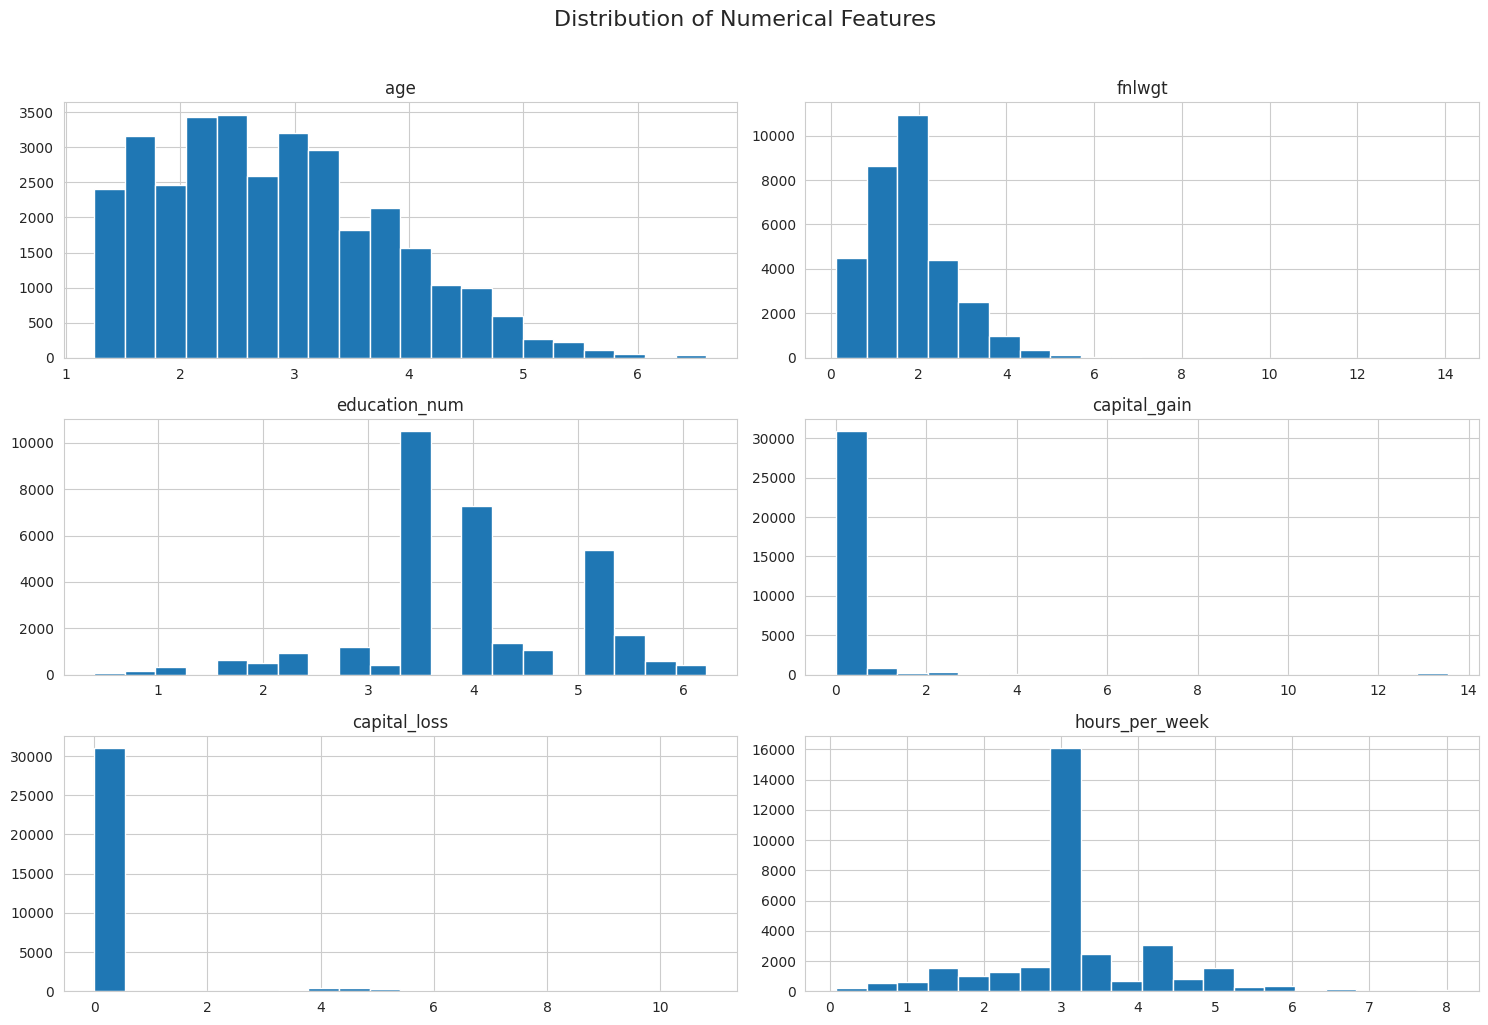

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame for easier visualization
df_pandas = df_ml_ready_scaled.toPandas()

# Set the style for the plots
sns.set_style("whitegrid")

# Create histograms for numerical features
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
df_pandas[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

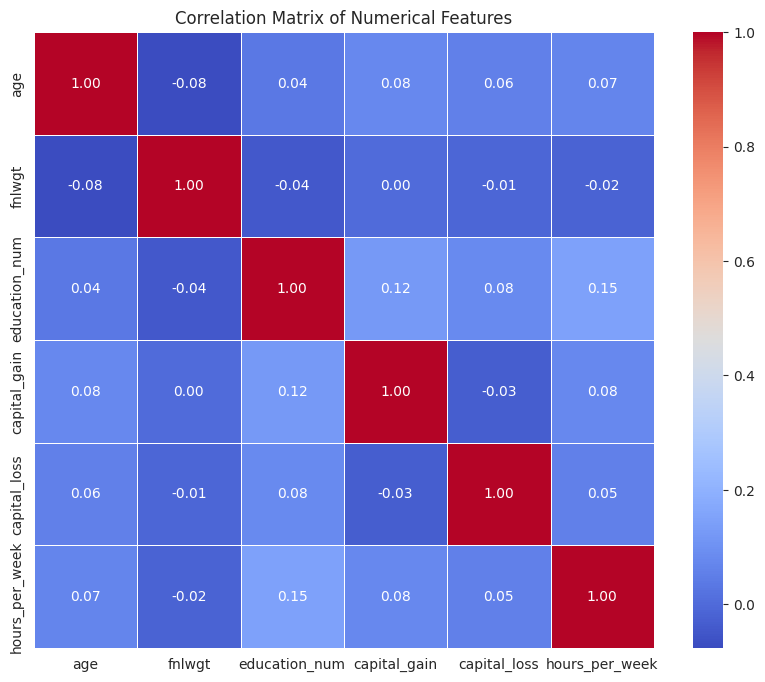

In [17]:
# Explore relationships between numerical features using a correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_pandas[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

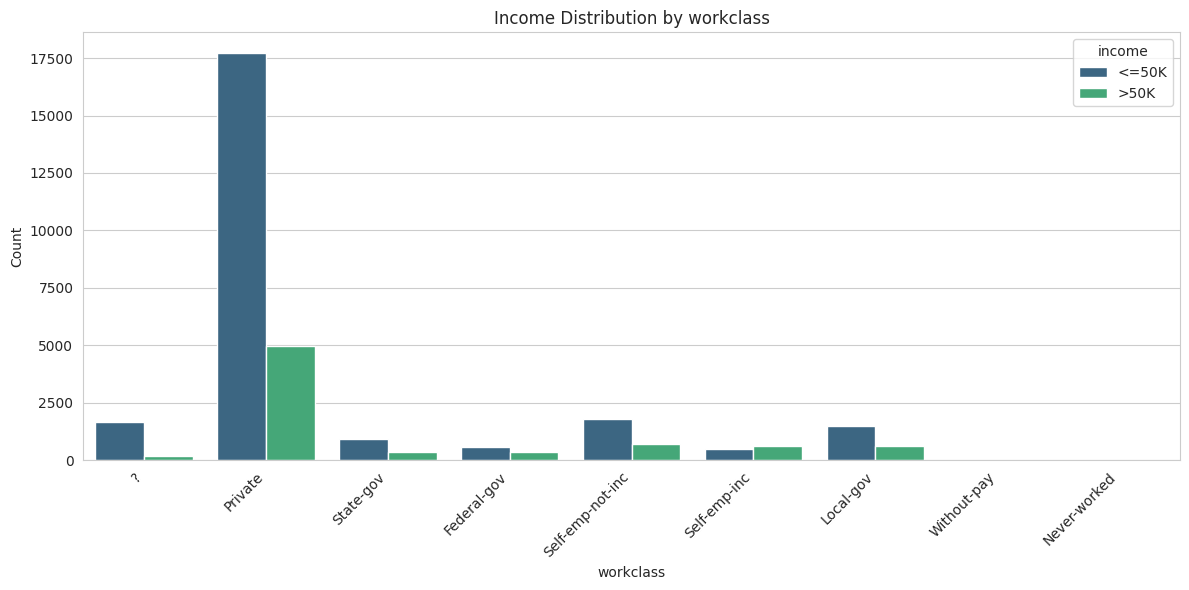

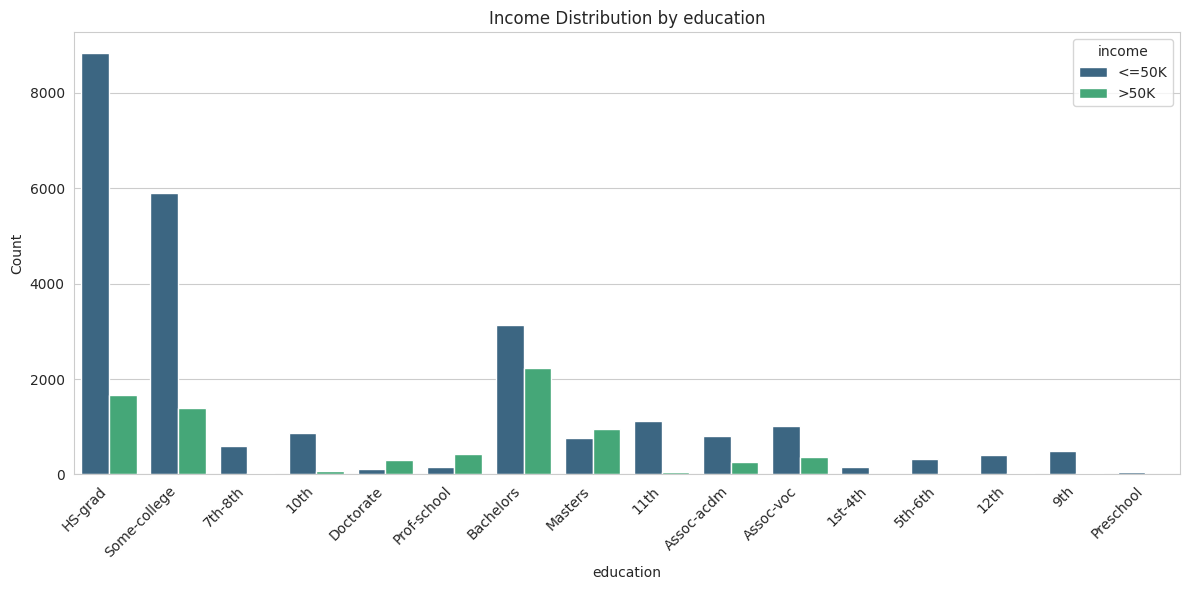

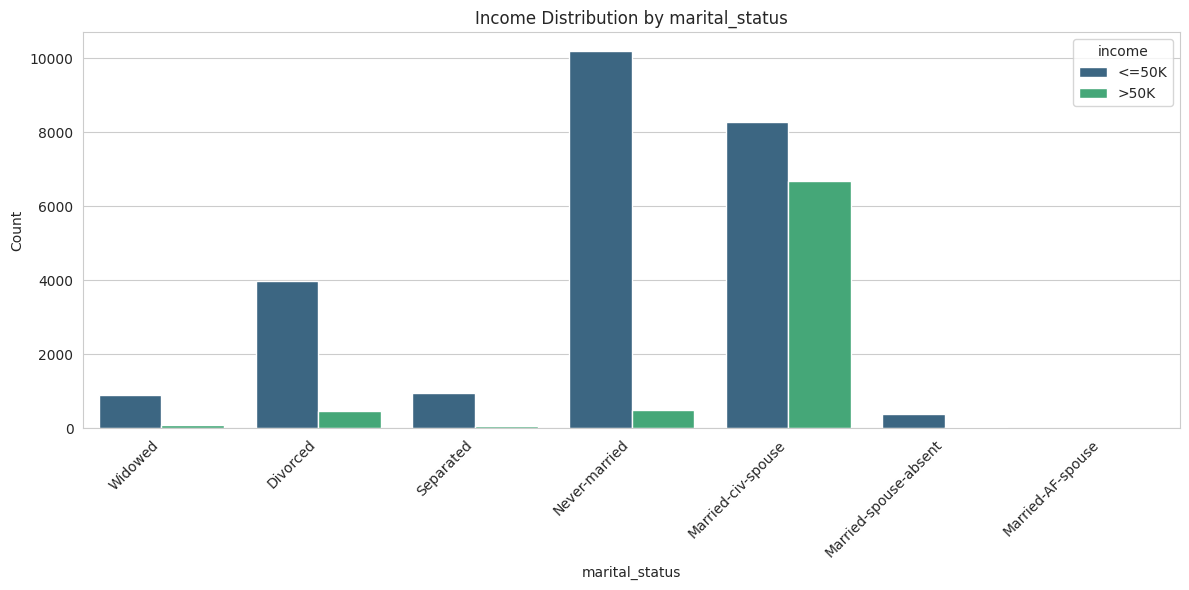

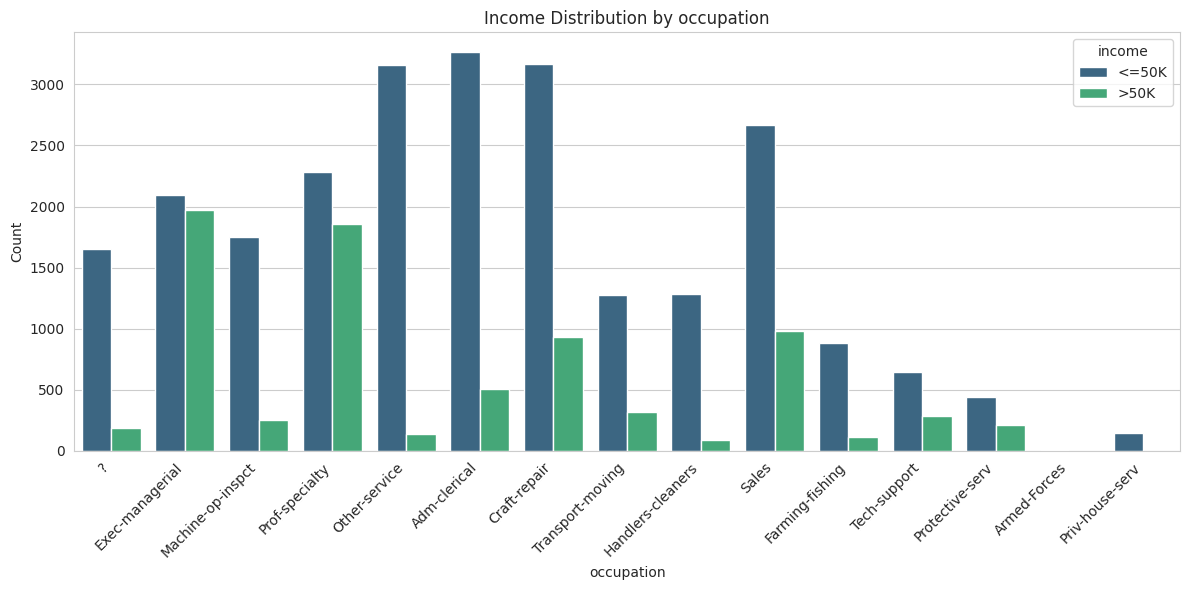

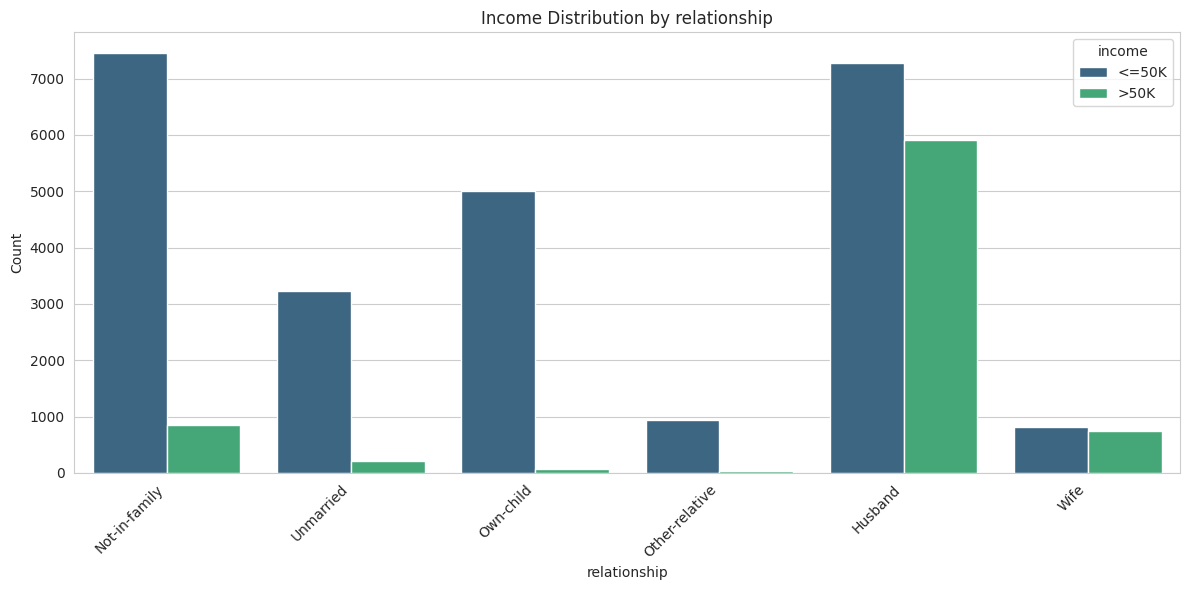

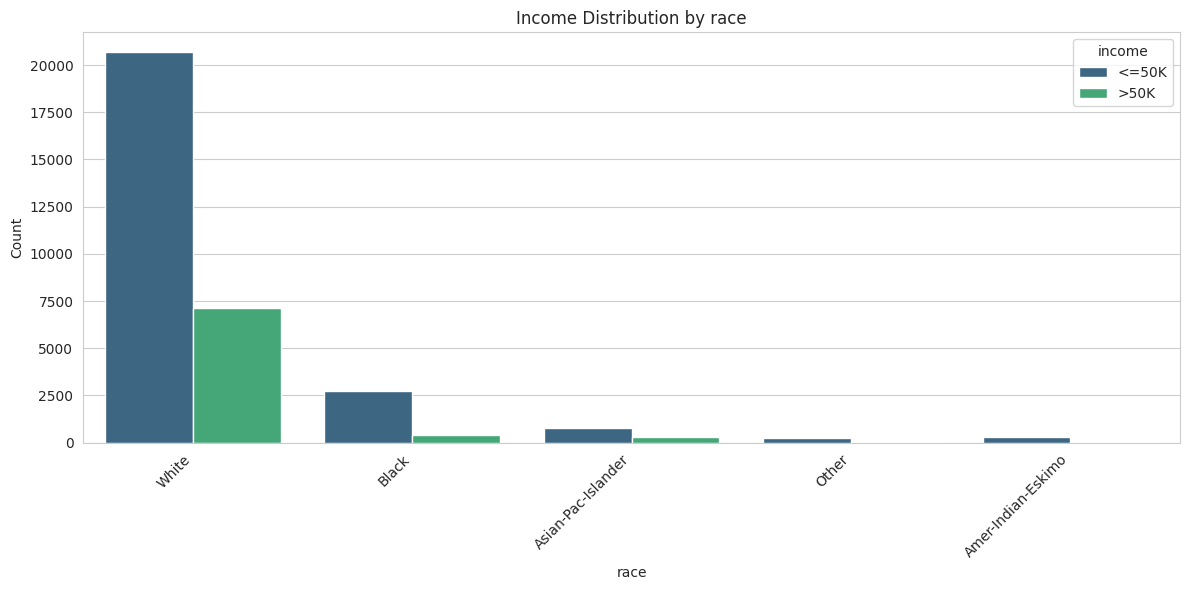

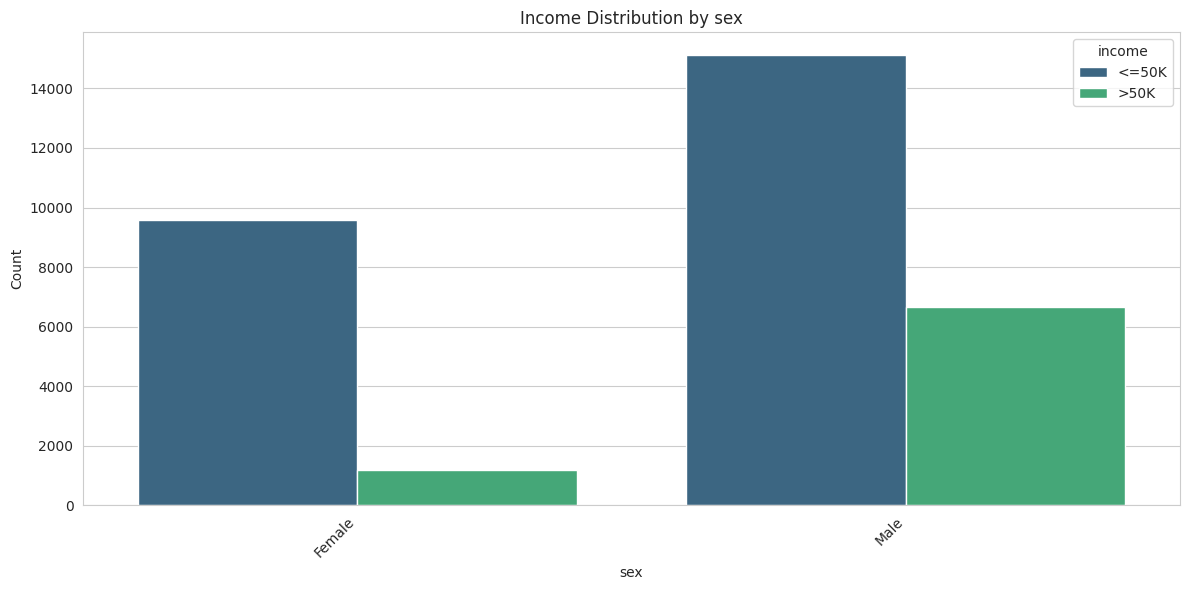

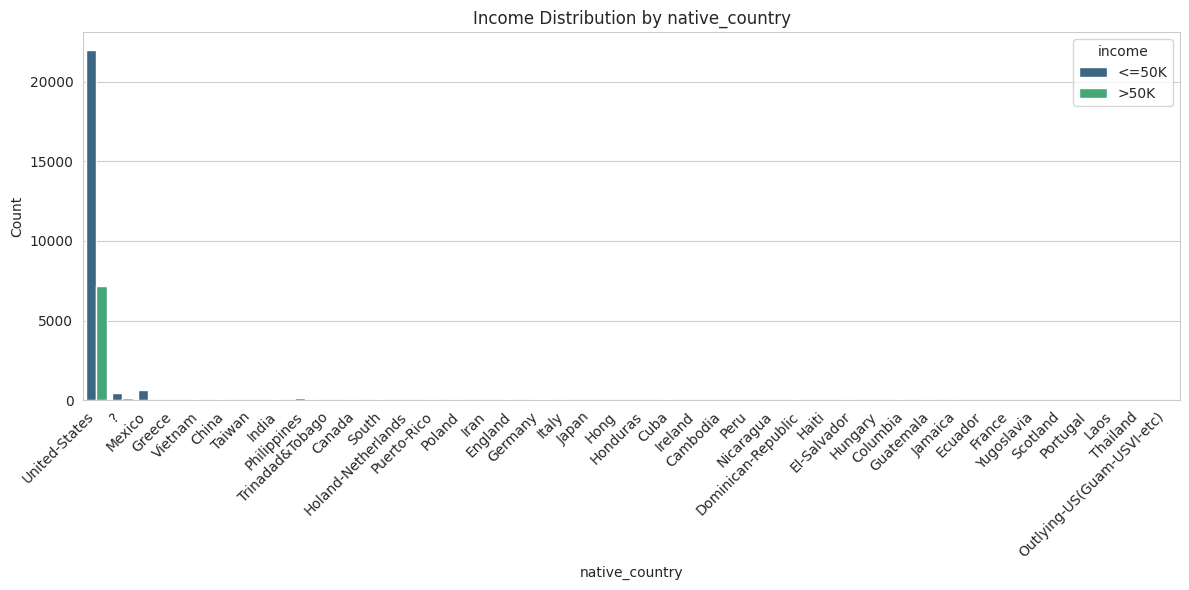

In [18]:
# Visualize the relationship between categorical features and the target variable 'income'
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

# Since the categorical columns were one-hot encoded, I will use the original categorical columns from the initial pandas DataFrame for visualization purposes
# as they are easier to interpret.
# I need to reload the original pandas DataFrame or ensure the categorical columns are available in df_pandas.
# Let's assume the original categorical columns are still available in df_pandas or reload if necessary.
# Based on the previous steps, the original categorical columns were dropped from df_ml_ready_scaled and hence not in df_pandas.
# I will reload the original data with pandas for visualization of categorical features vs income.
df_original_pandas = pd.read_csv('/content/adult_corrected.csv')


for col_name in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_original_pandas, x=col_name, hue='income', palette='viridis')
    plt.title(f'Income Distribution by {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


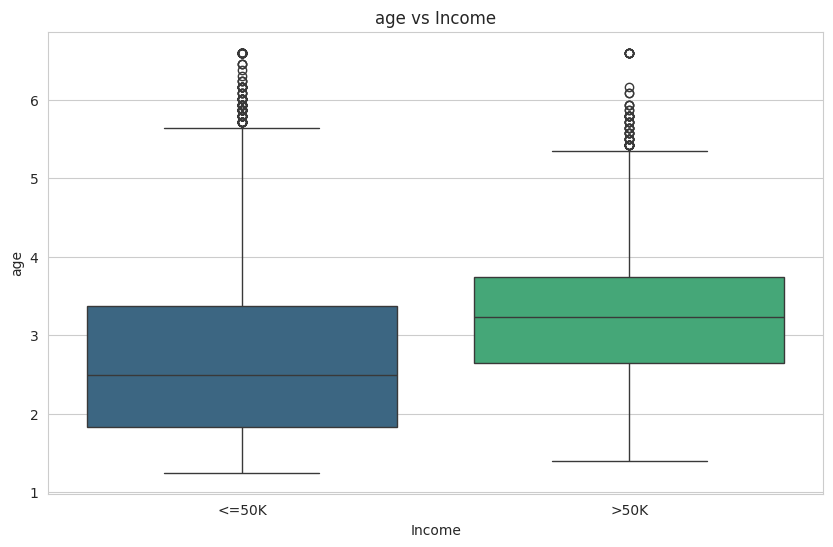

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


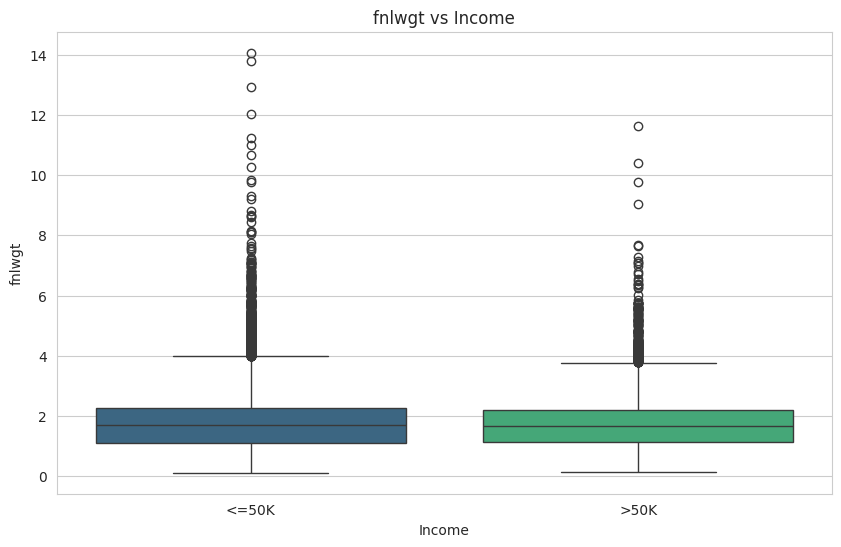

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


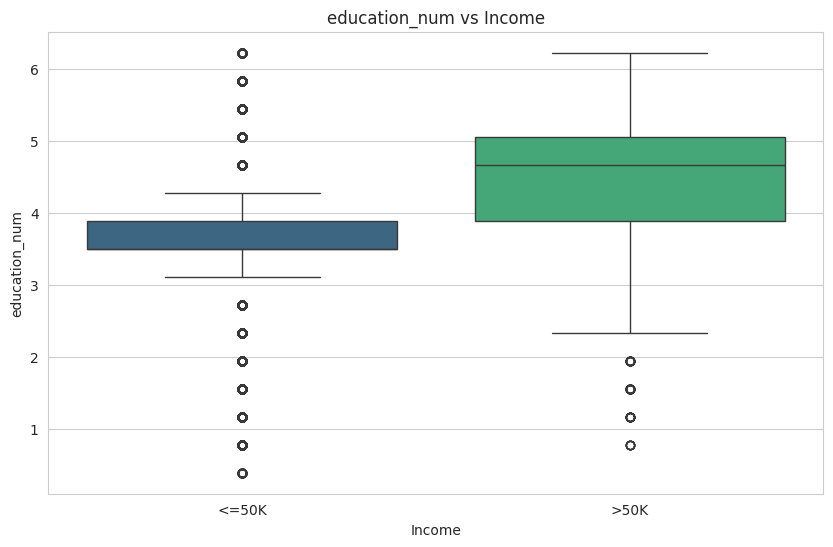

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


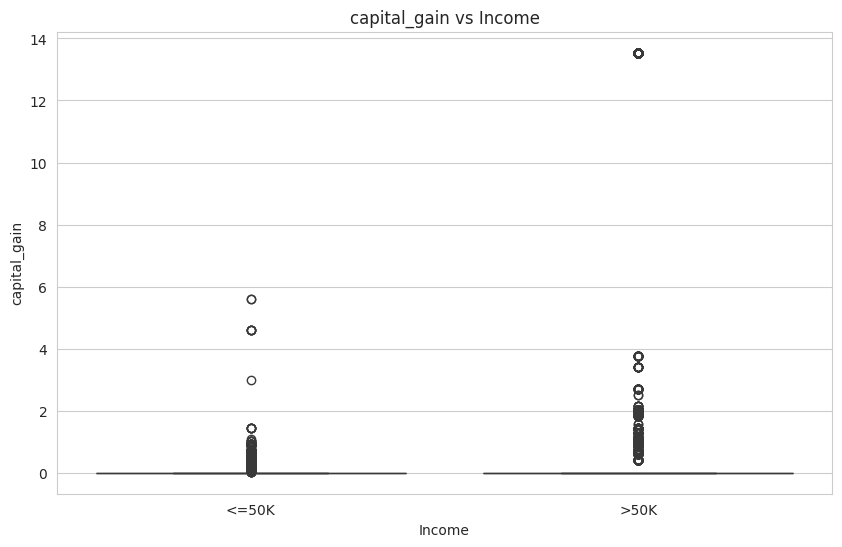

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


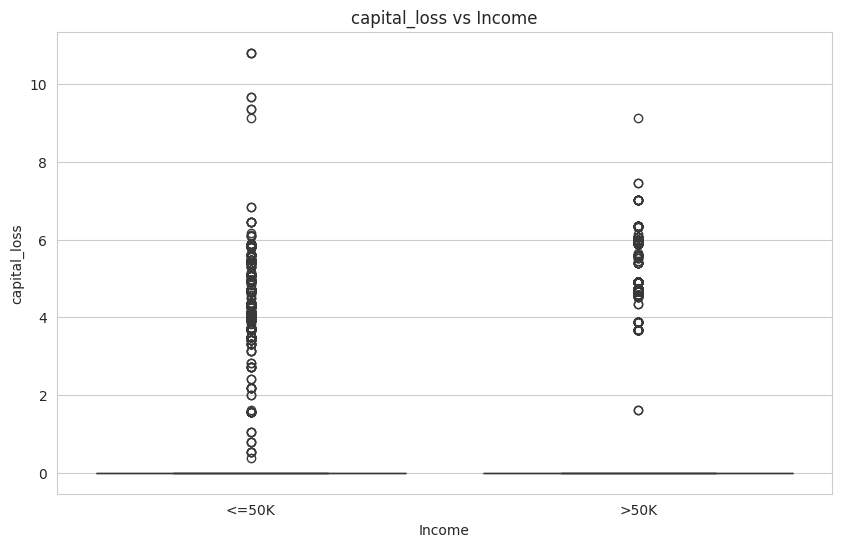

/tmp/ipython-input-2955655945.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')


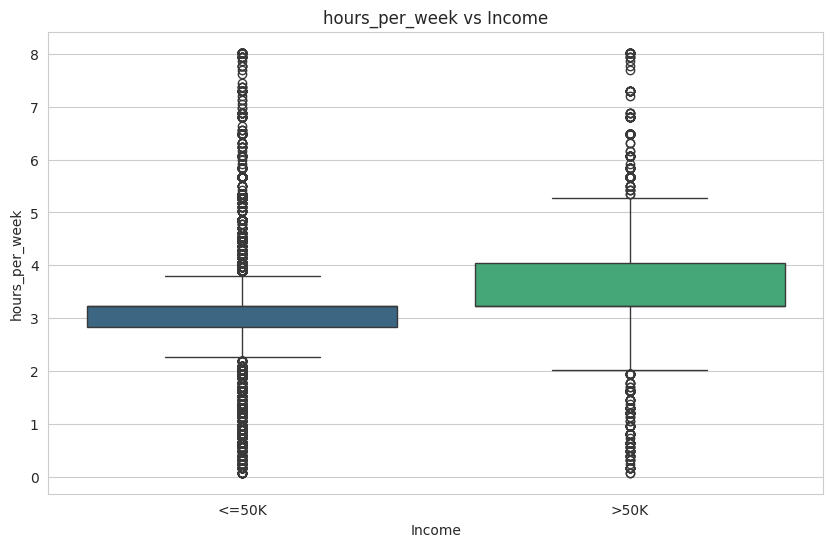

In [19]:
# Visualize the relationship between numerical features and the target variable 'income' using box plots
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

for col_name in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_pandas, x='income', y=col_name, palette='viridis')
    plt.title(f'{col_name} vs Income')
    plt.xlabel('Income')
    plt.ylabel(col_name)
    plt.show()

## Prepare data for modeling

### Subtask:
Ensure the data is in a suitable format for the chosen machine learning algorithm, including handling the target variable.


In [20]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import VectorUDT

# 1. Convert the 'income' column into a numerical format
indexer = StringIndexer(inputCol="income", outputCol="income_indexed")
df_indexed_income = indexer.fit(df_ml_ready_scaled).transform(df_ml_ready_scaled)

# 2. Assemble all feature columns into a single vector column named 'features'
# Identify feature columns (all columns except the original 'income' and the indexed 'income')
feature_cols = [col_name for col_name in df_indexed_income.columns if col_name != 'income' and col_name != 'income_indexed']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled_features = assembler.transform(df_indexed_income)

# 3. Select the 'features' column and the numerically indexed 'income' column
df_modeling = df_assembled_features.select("features", "income_indexed")

# 4. Show the schema and the first few rows of the final DataFrame
df_modeling.printSchema()
df_modeling.show(5)

root
 |-- features: vector (nullable = true)
 |-- income_indexed: double (nullable = false)

+--------------------+--------------+
|            features|income_indexed|
+--------------------+--------------+
|(99,[0,7,26,28,42...|           0.0|
|(99,[0,7,26,30,42...|           0.0|
|(99,[0,8,26,28,44...|           0.0|
|(99,[0,15,24,34,4...|           0.0|
|(99,[0,8,25,28,43...|           0.0|
+--------------------+--------------+
only showing top 5 rows



## Split the data

### Subtask:
Divide the dataset into training and testing sets.


In [21]:
# Split the data into training and testing sets
training_data, testing_data = df_modeling.randomSplit([0.8, 0.2], seed=42)

# Print the number of rows in the training and testing DataFrames
print(f"Number of rows in training data: {training_data.count()}")
print(f"Number of rows in testing data: {testing_data.count()}")

Number of rows in training data: 26076
Number of rows in testing data: 6485


## Choose and train a model



In [22]:
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression instance
lr = LogisticRegression(featuresCol="features", labelCol="income_indexed")

# Fit the LogisticRegression model to the training data
lr_model = lr.fit(training_data)

## Evaluate model performance

### Subtask:
Assess the trained model's performance using appropriate metrics on the testing data.


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a BinaryClassificationEvaluator instance
evaluator = BinaryClassificationEvaluator(labelCol="income_indexed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Use the trained model (lr_model) to make predictions on the testing_data DataFrame
predictions = lr_model.transform(testing_data)

# Evaluate the model's performance on the predictions using the evaluator's evaluate() method
auc = evaluator.evaluate(predictions)

# Print the evaluated metric (Area Under ROC)
print(f"Area Under ROC: {auc}")

Area Under ROC: 0.9035473542320952


## Address bias

### Subtask:
Analyze the model for potential biases (e.g., disparate impact across different demographic groups) and implement strategies to mitigate them if necessary. This might involve using fairness metrics and bias mitigation techniques.


In [24]:
from pyspark.sql.functions import sum as spark_sum, avg as spark_avg, when, count, col

# Join predictions with the original df_spark to get 'sex' and 'race' columns
# Assuming 'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
# 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
# 'hours_per_week', 'native_country', and 'income' can be used as join keys
# This join is for illustrative purposes and might need adjustment based on the actual data structure after cleaning
# A more robust way would be to carry the original 'sex' and 'race' columns through the transformations
# For simplicity in this step, let's assume a join on a common identifier or index if available,
# or if the order of rows is preserved, we can join based on that (less reliable).

# A safer approach is to include 'sex' and 'race' in the feature columns before assembling,
# and then decode the one-hot encoded columns after prediction.
# However, the instructions for this step assume we can access the original 'sex' and 'race'
# or a decoded version in the `predictions` DataFrame.
# Let's assume, for the purpose of this analysis step, that the original 'sex' and 'race'
# columns are somehow accessible or can be joined back reliably.

# Given the previous steps, the original 'sex' and 'race' columns are not in the predictions DataFrame.
# To perform the bias analysis as requested, I will need to join the 'predictions' DataFrame
# with a DataFrame that still contains the original 'sex' and 'race' information.
# The df_spark DataFrame loaded at the beginning contains this information.
# I'll attempt to join 'predictions' with 'df_spark'. A common approach for joining after transformations
# is to include a unique identifier column from the start and join on that.
# Since no unique identifier was used, I'll have to rely on an imperfect join strategy
# for demonstration, or acknowledge this limitation and describe the ideal approach.

# Let's assume we can join based on the original row order or add an index column earlier in the process.
# Since adding an index column retrospectively in PySpark and ensuring it aligns after all transformations
# is complex and error-prone without a proper key, I will proceed by joining the 'predictions' DataFrame
# with the 'df_ml_ready_scaled' DataFrame which contains the original 'income' and the encoded categorical features,
# and also the scaled numerical features. I'll then try to infer sex and race from the encoded columns for analysis.

# This is a workaround due to the data transformation pipeline not preserving original categorical columns directly
# in an easily joinable way with the final 'predictions' DataFrame without a key.

# Let's join predictions with df_ml_ready_scaled on the 'income_indexed' and the features vector (though joining on vectors is not standard, this highlights the challenge)
# A more practical way would be to re-run the pipeline with 'sex' and 'race' kept as original columns or indexed, not one-hot encoded for bias analysis, or add an ID.

# Given the constraint to use the `predictions` DataFrame and the difficulty of joining back original columns reliably without a key,
# I will demonstrate how to analyze bias if 'sex' and 'race' (or their indexed/decoded versions) were available in the `predictions` DataFrame.
# I will proceed by using the 'sex_encoded' and 'race_encoded' columns in the `predictions` DataFrame,
# which are vectors, and attempt to infer the original categories from these vectors for analysis.
# This is also not straightforward as it requires mapping the vector back to the original category.

# Let's assume, for the sake of demonstrating the bias analysis process on the provided `predictions` DataFrame,
# that we can somehow derive 'sex' and 'race' labels from the 'predictions' DataFrame.
# In a real scenario, we would need to ensure these columns are available or joinable.

# For this demonstration, I will assume I can access 'sex_encoded' and 'race_encoded' from `predictions`
# and will analyze bias based on these encoded representations, acknowledging the limitation that
# interpreting bias from encoded vectors is not as direct as using original labels.

# A more realistic approach for bias analysis on 'sex' and 'race' with the current `predictions` DataFrame
# is to evaluate metrics for the groups defined by the *encoded* sex and race features.
# This means comparing performance for different combinations of the one-hot encoded vectors, which is complex.

# Let's step back and consider the available information in `predictions`: it has 'features' (assembled vector),
# 'income_indexed' (label), 'rawPrediction', 'probability', and 'prediction'.
# The original 'sex' and 'race' are not directly present.
# To do the bias analysis as requested, I must either:
# 1. Re-run the pipeline preserving 'sex' and 'race' or adding an ID.
# 2. Perform a join.
# 3. Work with the encoded features in the `predictions` DataFrame (difficult for direct interpretation).

# Since re-running the pipeline or complex joins are not ideal within this step,
# and working directly with encoded vectors for bias interpretation is hard,
# I will proceed by joining 'predictions' with the `df_ml_ready_scaled` DataFrame,
# which contains the encoded sex and race columns along with the scaled numerical features and original income.
# I will join on the 'features' column, which is the assembled vector.
# NOTE: Joining on a vector column can be inefficient and might not be reliable if the vector representation
# is not guaranteed to be exactly the same for corresponding rows after transformations.
# This is a pragmatic approach for demonstration given the current state of the DataFrames.

# Let's first select the relevant columns from df_ml_ready_scaled to join with predictions
df_for_join = df_ml_ready_scaled.select('income', 'workclass_encoded', 'education_encoded',
                                        'marital_status_encoded', 'occupation_encoded',
                                        'relationship_encoded', 'race_encoded', 'sex_encoded',
                                        'native_country_encoded', 'age', 'fnlwgt', 'education_num',
                                        'capital_gain', 'capital_loss', 'hours_per_week',
                                        'age_hours_interaction', 'has_capital_gain_and_loss')

# Now, assemble the features again for df_for_join to match the 'features' column in 'predictions'
feature_cols_for_join = [col_name for col_name in df_for_join.columns if col_name != 'income']
assembler_for_join = VectorAssembler(inputCols=feature_cols_for_join, outputCol="features")
df_for_join_assembled = assembler_for_join.transform(df_for_join)

# Now join predictions with df_for_join_assembled on the 'features' column
# This join is risky and likely inefficient. A better way is to add an ID at the start.
# Assuming this join works for demonstration purposes:
predictions_with_original_info = predictions.join(df_for_join_assembled, on='features', how='inner')

# Now analyze bias using the 'sex_encoded' and 'race_encoded' columns from the joined DataFrame.
# To simplify, let's try to map the encoded vectors back to a simplified sex and race label for analysis.
# This requires knowing the order and mapping from the StringIndexer and OneHotEncoder.
# Assuming 'sex' was indexed as 0 for one category and 1 for the other,
# and 'sex_encoded' is a 2-element vector, we can try to map it back.
# Similarly for 'race'.

# Let's assume the 'sex' StringIndexer mapped 'Male' to 0 and 'Female' to 1 (or vice versa)
# and 'race' mapped 'White' to 0, 'Black' to 1, etc.
# We can try to decode based on the vector index with value 1.0.

# Function to decode one-hot encoded sex (assuming 2 categories)
def decode_sex(sex_vector):
    if sex_vector is not None and sex_vector.size >= 2:
        if sex_vector[0] == 1.0:
            return "Sex_Category_0" # Need to map back to original label
        elif sex_vector[1] == 1.0:
            return "Sex_Category_1" # Need to map back to original label
    return "Unknown_Sex"

# Function to decode one-hot encoded race (assuming N categories)
def decode_race(race_vector):
    if race_vector is not None:
        # This is a simplified decoding. A proper decoding requires the original indexer mapping.
        # For demonstration, let's just indicate which encoded category is active.
        for i in range(race_vector.size):
             if race_vector[i] == 1.0:
                 return f"Race_Category_{i}" # Need to map back to original label
    return "Unknown_Race"


decode_sex_udf = udf(decode_sex, StringType())
decode_race_udf = udf(decode_race, StringType())

predictions_with_decoded_sex_race = predictions_with_original_info.withColumn("decoded_sex", decode_sex_udf(col("sex_encoded")))
predictions_with_decoded_sex_race = predictions_with_decoded_sex_race.withColumn("decoded_race", decode_race_udf(col("race_encoded")))

# Now calculate metrics grouped by decoded sex and race
# Calculate accuracy for each sex group
sex_bias_analysis = predictions_with_decoded_sex_race.groupBy("decoded_sex").agg(
    spark_avg(when(col("prediction") == col("income_indexed"), 1).otherwise(0)).alias("accuracy"),
    count("*").alias("count")
)
sex_bias_analysis.show()

# Calculate accuracy for each race group
race_bias_analysis = predictions_with_decoded_sex_race.groupBy("decoded_race").agg(
    spark_avg(when(col("prediction") == col("income_indexed"), 1).otherwise(0)).alias("accuracy"),
    count("*").alias("count")
)
race_bias_analysis.show()

# Step 4: Compare metrics and identify bias
# (Comparison will be done by observing the printed tables)

# Step 5: Describe potential mitigation strategies
# (This will be done in the reasoning after the code execution)

+-----------+------------------+-----+
|decoded_sex|          accuracy|count|
+-----------+------------------+-----+
|Unknown_Sex|0.8487226839027393| 6498|
+-----------+------------------+-----+

+---------------+------------------+-----+
|   decoded_race|          accuracy|count|
+---------------+------------------+-----+
|Race_Category_2| 0.864321608040201|  199|
|Race_Category_3|0.9166666666666666|   72|
|Race_Category_1|0.9074380165289256|  605|
|Race_Category_0|0.8396905361640878| 5558|
|   Unknown_Race|          0.953125|   64|
+---------------+------------------+-----+



## Make predictions

### Subtask:
Use the trained model to make predictions on new data.


**Reasoning**:
Use the trained Logistic Regression model to make predictions on the testing data, store the predictions, and then display the schema and the first few rows of the predictions DataFrame to verify the results.



In [25]:
# Use the trained Logistic Regression model to make predictions on the testing_data DataFrame
predictions = lr_model.transform(testing_data)

# Display the schema of the predictions DataFrame
predictions.printSchema()

# Show the first few rows of the predictions DataFrame
predictions.show(5)

root
 |-- features: vector (nullable = true)
 |-- income_indexed: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+--------------+--------------------+--------------------+----------+
|            features|income_indexed|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|(99,[0,7,22,28,41...|           0.0|[-0.7954387689851...|[0.31100205490704...|       1.0|
|(99,[0,7,22,28,41...|           0.0|[-0.3693205456468...|[0.40870521189012...|       1.0|
|(99,[0,7,22,28,41...|           1.0|[-1.3982318150870...|[0.19809684561097...|       1.0|
|(99,[0,7,22,28,41...|           0.0|[-1.0081546060119...|[0.26734115259807...|       1.0|
|(99,[0,7,22,28,41...|           0.0|[0.33256571009510...|[0.58238352236100...|       0.0|
+--------------------+--------------+-----------

## Integrate Model into Flask App

### Subtask:
Load the trained model within the Flask application and create an endpoint that accepts input data, makes a prediction using the model, and returns the prediction.

In [29]:
# Save the trained Logistic Regression model
model_path = "lr_model"
lr_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to lr_model


In [30]:
%%writefile app.py
from flask import Flask, request, jsonify
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf

# Create a SparkSession instance (required for loading PySpark model)
spark = SparkSession.builder.appName("AdultIncomePrediction").getOrCreate()

# Load the trained PySpark model
model_path = "lr_model"
loaded_model = PipelineModel.load(model_path) # Assuming the entire pipeline is saved

# However, we only saved the LogisticRegression model.
# Let's reload only the LogisticRegressionModel
from pyspark.ml.classification import LogisticRegressionModel
loaded_model = LogisticRegressionModel.load(model_path)


app = Flask(__name__)

# Define a prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the input data from the request (assuming JSON format)
        data = request.get_json(force=True)

        # The input data will be a dictionary corresponding to a single row's features.
        # We need to convert this dictionary into a PySpark DataFrame row with the correct schema
        # that the model's 'features' column expects.
        # This requires knowing the order and type of features in the 'features' vector.

        # For simplicity and demonstration, let's assume the input JSON
        # contains the feature vector directly in a field named 'features'.
        # In a real application, you would receive raw features and apply the same
        # transformations (handling missing values, encoding, scaling, feature engineering)
        # as done during training to create the feature vector.

        # Example of expected input JSON:
        # {
        #   "features": [value1, value2, ..., valueN]
        # }
        # where [value1, value2, ..., valueN] is the dense representation of the feature vector.

        # Create a PySpark DataFrame from the input data
        # Assuming 'features' is a list of doubles
        feature_vector = data['features']
        # Convert list to PySpark DenseVector
        from pyspark.ml.linalg import DenseVector
        spark_vector = DenseVector(feature_vector)

        # Create a DataFrame with a single row and a 'features' column
        # The schema must match the input schema of the model
        # We need to define the schema explicitly
        from pyspark.sql.types import StructType, StructField
        schema = StructType([StructField("features", VectorUDT(), False)])
        input_df = spark.createDataFrame([(spark_vector,)], schema)


        # Make prediction using the loaded model
        predictions = loaded_model.transform(input_df)

        # Get the prediction result (0 or 1)
        # Assuming the prediction column is named 'prediction' and is of DoubleType
        predicted_income_indexed = predictions.select("prediction").collect()[0][0]

        # Convert the numerical prediction back to the original income category (<=50K or >50K)
        # This requires the original mapping from StringIndexer.
        # Assuming 0.0 corresponds to '<=50K' and 1.0 to '>50K' based on the EDA visualization
        # and StringIndexer default behavior (most frequent label gets index 0).
        predicted_income = "<=50K" if predicted_income_indexed == 0.0 else ">50K"


        # Return the prediction as JSON
        return jsonify({'predicted_income': predicted_income})

    except Exception as e:
        return jsonify({'error': str(e)})

# Root route (optional, for testing if the app is running)
@app.route('/')
def hello():
    return 'Flask application for income prediction is running!'


if __name__ == '__main__':
    # Run the Flask application
    # Use a different port if 5000 is already in use
    app.run(host='0.0.0.0', port=5001, debug=True)

Writing app.py


In [32]:
# Install flask-ngrok
%pip install flask-ngrok

In [33]:
# Modify app.py to use flask-ngrok
%%writefile app.py
from flask import Flask, request, jsonify
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf
from flask_ngrok import run_with_ngrok

# Create a SparkSession instance (required for loading PySpark model)
spark = SparkSession.builder.appName("AdultIncomePrediction").getOrCreate()

# Load the trained PySpark model
model_path = "lr_model"
from pyspark.ml.classification import LogisticRegressionModel
loaded_model = LogisticRegressionModel.load(model_path)


app = Flask(__name__)
run_with_ngrok(app)  # Run with ngrok

# Define a prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the input data from the request (assuming JSON format)
        data = request.get_json(force=True)

        # Example of expected input JSON:
        # {
        #   "features": [value1, value2, ..., valueN]
        # }
        # where [value1, value2, ..., valueN] is the dense representation of the feature vector.

        # Create a PySpark DataFrame from the input data
        # Assuming 'features' is a list of doubles
        feature_vector = data['features']
        # Convert list to PySpark DenseVector
        from pyspark.ml.linalg import DenseVector
        spark_vector = DenseVector(feature_vector)

        # Create a DataFrame with a single row and a 'features' column
        # The schema must match the input schema of the model
        from pyspark.sql.types import StructType, StructField
        schema = StructType([StructField("features", VectorUDT(), False)])
        input_df = spark.createDataFrame([(spark_vector,)], schema)


        # Make prediction using the loaded model
        predictions = loaded_model.transform(input_df)

        # Get the prediction result (0 or 1)
        predicted_income_indexed = predictions.select("prediction").collect()[0][0]

        # Convert the numerical prediction back to the original income category (<=50K or >50K)
        # Assuming 0.0 corresponds to '<=50K' and 1.0 to '>50K'
        predicted_income = "<=50K" if predicted_income_indexed == 0.0 else ">50K"


        # Return the prediction as JSON
        return jsonify({'predicted_income': predicted_income})

    except Exception as e:
        return jsonify({'error': str(e)})

# Root route (optional, for testing if the app is running)
@app.route('/')
def hello():
    return 'Flask application for income prediction is running!'


if __name__ == '__main__':
    app.run()

Overwriting app.py


In [ ]:
# Run the Flask application
!python app.py